## ${\bf Project}$

### Hydrodynamics
The equations of hydrodynamics are
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \,\mathsf{I}] & = 0 \\
\partial_t E + \mathbf{\nabla} \cdot [(E + P)\, \mathbf{v}] & = 0\,,
\end{align}
where $\rho$ is density, $\mathbf{v}$ is velocity, $P$ is pressure, and $E$ is the total energy density. $E = \rho e + {1 \over 2} \rho v^2$, and $e$ is the internal energy per mass. This is complemented by an equation of state $P = (\gamma - 1)\rho e$. $\mathsf{I}$ is the identity matrix, so that $\mathbf{\nabla} \cdot [P\,\mathsf{I}] = \mathbf{\nabla}P$.

This can also be written in the Lagranian form
\begin{align}
\partial_t \rho & = - \mathbf{v} \cdot \mathbf{\nabla} \rho
- \rho \mathbf{\nabla} \cdot \mathbf{v} \\
\partial_t \mathbf{v} & = - (\mathbf{v} \cdot \mathbf{\nabla}) \mathbf{v}
- \frac{1}{\rho} \mathbf{\nabla} P  \\
\partial_t P &= - \mathbf{v} \cdot \mathbf{\nabla} P
- \gamma P \mathbf{\nabla} \cdot \mathbf{v}\,,
\end{align}
where the advective derivative ($-\mathbf{v} \cdot \mathbf{\nabla}$) is explicit.

In the special case where the temperature is constant the equations simplify to
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \,\mathsf{I}] & = 0
\end{align}
and $P = c_s^2 \rho$, where $c_s^2 = k_b T / \mu m_p$ is the isothermal sound speed. To keep it simlpe, we will start by considering isothermal hydrodynamics. You will the yourselves add the energy equation.


To simplfy the equations we will write the system in vector notation with a _state vector_ $U$, and a _flux vector_ $F$, and assume we have one dimension. Then
\begin{align}
U &= (\rho, \rho u, E_{int}+\frac{\rho\ u^{2}}{2}) \\
F &= (\rho u, \rho u u + P, (E_{int}+\frac{\rho\ u^{2}}{2}+ P)u) \\
\partial_t U + \partial_x F &= 0
\end{align}




The main focus of this project would be the implementantion of the HLLC Riemman solver and compare it with the simpler version of that which is the HLL one though some shock tube problems. Moreover we are going to try to implement a 2D version of the HLLC Riemann solver in order to elaborate on the blast wave problem (2D problem). It is worth noting the notebook contains the three variants of the HLLC, that are depicted on the book "Riemann Solvers And Numerical Methods" as well as the faster version of them.

Import of libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import time

### Classes

Define the hydrodynamic class. Via this class we are enabled to set a hydrodynamic problem and define its characteristics e.g density, pressure etc.

In [2]:
# Define an hydro state including all auxiliary scalars and coordinates in a class
class hd():
    def __init__(self,n,gamma,cs=1.,Lbox=1.0):
        dx, x = coordinates(n, Lbox=Lbox)
        self.n = n                             # number of points
        self.dx = dx                           # cell size
        self.Lbox = Lbox                       # Box size
        self.x = x                             # coordinate axis
        self.gamma = gamma                     # adiabatic index
        self.cs = cs                           # initial sound speed, if isothermal it is fixed
        self.t = 0.                            # time
        self.rho = np.ones(n)                  # density  
        self.Px  = np.zeros(n)                 # momentum density = rho*velocity_x
        if gamma != 1.0:                       # non-isothermal
            Pressure = cs**2*self.rho / gamma
            Eint = Pressure / (self.gamma - 1.)
            self.Etot = Eint   # total energy

    # Compute velocity from state vector
    def velocity(self):
        """ Compute velocity from conservative variables """
        return self.Px / self.rho

    # Compute pressure from state vector
    def pressure(self):
        """ Compute pressure from conservative variables """
        if self.gamma==1.0:
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5 * self.Px**2 / self.rho # Internal energy
            P = (self.gamma-1.)*Eint
        return P

    # compute sound speed
    def sound_speed(self):
        """ Sound speed for HD """
        # if gamma=1 gas is isothermal, and sound speed is a property of the equation of state
        if (self.gamma==1.):
            return self.cs
        else:
            P = self.pressure()
            cs = np.sqrt(abs(self.gamma*P/self.rho))
            return cs

    # Courant condition with default Courant number=0.2 for a fluid
    # maximum propagation velocity is max(|v| + sound speed), where max is taken over all cells
    def Courant(self,Cdt=0.2):
        """ Courant condition for HD """
        speed = abs(self.velocity())
        dt = Cdt * self.dx / np.max(speed + self.sound_speed())
        return dt

In [3]:
class void():
    """ Empty class, used to create ad hoc objects """
    pass

Define the methods for calculating slopes 

In [4]:
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def no_slope(f):
    return np.zeros_like(f)

# Centered derivative; e.g. no slope limiter. This is unstable!
def Cen(f):
    ls = left_slope(f) # left slope
    rs=np.roll(ls,-1)  # roll down once (giving the slope to the right)
    return 0.5*(ls+rs) # the average of the left and right slopes is simply the centered derivative (deriv(f))

# MinMod slope limiter
def MinMod(f):
    ls = left_slope(f)                      # left slope
    rs = np.roll(ls,-1)                     # right slope
    sign = np.ones(ls.shape)                # start with making sign equal +1
    sign[np.where(ls < 0.0)] -= 1.0         # where left slope is negative, make sign 0
    sign[np.where(rs < 0.0)] -= 1.0         # if left *and* right slope are negative, sign is -1, if only right slope is negative, sign is 0
    return np.minimum(abs(ls),abs(rs))*sign # return the smallest size of the two slopes with correct sign, but zero if they disagree about sign

# MonCen slope limiter
def MonCen(f):
    ls = left_slope(f)                      # left slope
    rs = np.roll(ls,-1)                     # right slope
    cs = np.zeros_like(ls)                  # MonCen starts out as zero slope
    w  = np.where(ls*rs>0.0)                # Where both slopes agree in sign, we compute it
    cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])     # MonCen slope is the harmonic average of the left and right state
    return cs


Define a function that affects the images being created

In [5]:
def wide_fig(title='',s=''):
    if title=='':
        title='{}  Courant={:.2f}'.format(s,C)
    plt.figure(figsize=(14,4))
    plt.title(title);

In [6]:
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D #ρ
    U.mU = q.D*q.U #ρu
    if gamma!=1:
        Eint=q.P/(q.gamma-1)
        U.Etot=Eint+0.5*(q.D*q.U*q.U) #energy
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D  = U.mU #ρu
    F.mU = U.mU * q.U + q.P #ρuu+P
    if gamma!=1:
        F.Etot=(U.Etot+q.P)*q.U #(E+P)u
    return F

Define the LLF and HLL riemann solvers as well as the three version of the HLLC Riemann solvers that are presented to the book called "Riemann Solvers and Numerical Methods for Fluid Dynamics".

In [7]:
# LLF is the most diffuse Riemann solver. But also the most stable.
# ql = (density, velocity, pressure) = (D, U, P), qr are state vectors for the _primitive_ variables 
def LLF(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum absolute wave speed for left and right state
    cmax = np.maximum(np.abs(ql.U)+c_max,np.abs(qr.U)+c_max)
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # LLF flux based on maximum wavespeed.
    # The general form is "(F_left + F_right - cmax*(U_right - U_left)) / 2"
    # where U is the state vector of the conserved variables
    Flux = void()
    Flux.D  = 0.5*(Fl.D  + Fr.D  - cmax*(Ur.D  - Ul.D))
    Flux.mU = 0.5*(Fl.mU + Fr.mU - cmax*(Ur.mU - Ul.mU))
    Flux.Etot = 0.5*(Fl.Etot + Fr.Etot - cmax*(Ur.Etot - Ul.Etot))
    return Flux

In [8]:
def HLL(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds. If SL < 0 and SR > 0 then mix state appropriately
    # The general form is
    #    (SR * F_left - SL * F_right + SL * SR *(U_right - U_left)) / (SR - SL)
    # where U is the state vector of the conserved variables
    Flux=void()
    Flux.D  = (SR*Fl.D  - SL*Fr.D  + SL*SR*(Ur.D  - Ul.D )) / (SR - SL)
    Flux.mU = (SR*Fl.mU - SL*Fr.mU + SL*SR*(Ur.mU - Ul.mU)) / (SR - SL)
    if gamma!=1:
        Flux.Etot = (SR*Fl.Etot - SL*Fr.Etot + SL*SR*(Ur.Etot - Ul.Etot)) / (SR - SL)

    return Flux

In [9]:
def HLLC0(ql,qr): #Variant 0 of HLLC Riemann Solver
    n=len(ql.U)
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U)
    S_star=nominator/denominator
    
    #For this variant of the HLLC solver we need to calculate the total energy.
    #We know that Etotal=Eint+0.5(ρ u^2), Eint=P/(γ-1). Thus in each case we 
    #use the qr.D,qr.U,ql.D,ql.U respectively.
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star=np.zeros((3,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332. 
    #Now, in our case it is highly importan to mention that in the book at the relation (10.73)
    #the relation that connects U*k with the energy, the term Ek/ρk exists due to the 
    #fact that the Ek value is basically ρΕk. So in our case we should use only the value of
    #the energy we have computed previously!
    for i in range(n):
        if SL[i]>0:
            F_star[0,i]+=Fl.D[i]
            F_star[1,i]+=Fl.mU[i]
            F_star[2,i]+=Fl.Etot[i]
        elif SL[i]<=0 and S_star[i]>=0:
            a=ql.D[i]*((SL[i]-ql.U[i])/(SL[i]-S_star[i]))
            F_star[0,i]+=Fl.D[i]+SL[i]*(a*1-Ul.D[i])
            F_star[1,i]+=Fl.mU[i]+SL[i]*(a*S_star[i]-Ul.mU[i])
            Energy_left=(ql.P[i]/(ql.gamma-1))+0.5*(ql.D[i]*ql.U[i]*ql.U[i])
            b=(Energy_left/ql.D[i])+(S_star[i]-ql.U[i])*(S_star[i]+ql.P[i]/(ql.D[i]*(SL[i]-ql.U[i])))            
            F_star[2,i]+=Fl.Etot[i]+SL[i]*(a*b-Ul.Etot[i])
        elif S_star[i]<0 and SR[i]>0:
            a=qr.D[i]*((SR[i]-qr.U[i])/(SR[i]-S_star[i]))
            F_star[0,i]+=Fr.D[i]+SR[i]*(a*1-Ur.D[i])
            F_star[1,i]+=Fr.mU[i]+SR[i]*(a*S_star[i]-Ur.mU[i])
            Energy_right=(qr.P[i]/(qr.gamma-1))+0.5*(qr.D[i]*qr.U[i]*qr.U[i])
            b=(Energy_right/qr.D[i])+(S_star[i]-qr.U[i])*(S_star[i]+qr.P[i]/(qr.D[i]*(SR[i]-qr.U[i])))            
            F_star[2,i]+=Fr.Etot[i]+SR[i]*(a*b-Ur.Etot[i])
        else:
            F_star[0,i]+=Fr.D[i]
            F_star[1,i]+=Fr.mU[i]
            F_star[2,i]+=Fr.Etot[i]
    #We create the object of Flux
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.Etot=np.copy(F_star[2,:])
    return Flux
    

In [10]:
def HLLC1(ql,qr): #Variant 1 of HLLC Riemann Solver
    #number of points
    n=len(ql.U)
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U) #pR-pL+dL*uL*(SL-uL)-dR*uR*(SR-uR)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U) #dL(SL-uL)-dR(SR-uR)
    S_star=nominator/denominator
    

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star=np.zeros((3,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332
   
    D=[0,1,0,0,S_star]
    for i in range(n):
        if SL[i]>0:
            F_star[0,i]+=Fl.D[i]
            F_star[1,i]+=Fl.mU[i]
            F_star[2,i]+=Fl.Etot[i]
        elif S_star[i]>=0 and SL[i]<=0:
            denom=SL[i]-S_star[i]
            F_star[0,i]+=(S_star[i]*(SL[i]*Ul.D[i]-Fl.D[i])+SL[i]*(ql.P[i]+ql.D[i]*(SL[i]-ql.U[i])*(S_star[i]-ql.U[i]))*D[0])/denom
            F_star[1,i]+=(S_star[i]*(SL[i]*Ul.mU[i]-Fl.mU[i])+SL[i]*(ql.P[i]+ql.D[i]*(SL[i]-ql.U[i])*(S_star[i]-ql.U[i]))*D[1])/denom
            F_star[2,i]+=(S_star[i]*(SL[i]*Ul.Etot[i]-Fl.Etot[i])+SL[i]*(ql.P[i]+ql.D[i]*(SL[i]-ql.U[i])*(S_star[i]-ql.U[i]))*S_star[i])/denom
        elif S_star[i]<0 and SR[i]>0:
            denom=SR[i]-S_star[i]
            F_star[0,i]+=(S_star[i]*(SR[i]*Ur.D[i]-Fr.D[i])+SR[i]*(qr.P[i]+ql.D[i]*(SR[i]-qr.U[i])*(S_star[i]-qr.U[i]))*D[0])/denom
            F_star[1,i]+=(S_star[i]*(SR[i]*Ur.mU[i]-Fr.mU[i])+SR[i]*(qr.P[i]+ql.D[i]*(SR[i]-qr.U[i])*(S_star[i]-qr.U[i]))*D[1])/denom
            F_star[2,i]+=(S_star[i]*(SR[i]*Ur.Etot[i]-Fr.Etot[i])+SR[i]*(qr.P[i]+ql.D[i]*(SR[i]-qr.U[i])*(S_star[i]-qr.U[i]))*S_star[i])/denom
        else:
            F_star[0,i]+=Fr.D[i]
            F_star[1,i]+=Fr.mU[i]
            F_star[2,i]+=Fr.Etot[i]
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.Etot=np.copy(F_star[2,:])



    return Flux

In [11]:
def HLLC2(ql,qr): #Variant 2 of HLLC Riemann Solver
    #number of points
    n=len(ql.U)
    
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U) #pR-pL+dL*uL*(SL-uL)-dR*uR*(SR-uR)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U) #dL(SL-uL)-dR(SR-uR)
    S_star=nominator/denominator
    
    #calculate pLR (page 332 in Riemman book)
    pLR=np.copy(0.5*(ql.P+qr.P+ql.D*(SL-ql.U)*(S_star-ql.U)+qr.D*(SR-qr.U)*(S_star-qr.U)))

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
     #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star=np.zeros((3,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332
    D=[0,1,0,0,S_star]
    
    for i in range(n):
        if SL[i]>0:
            F_star[0,i]+=Fl.D[i]
            F_star[1,i]+=Fl.mU[i]
            F_star[2,i]+=Fl.Etot[i]
        elif S_star[i]>=0 and SL[i]<=0:
            denom=SL[i]-S_star[i]
            F_star[0,i]+=(S_star[i]*(SL[i]*Ul.D[i]-Fl.D[i])+SL[i]*pLR[i]*D[0])/denom
            F_star[1,i]+=(S_star[i]*(SL[i]*Ul.mU[i]-Fl.mU[i])+SL[i]*pLR[i]*D[1])/denom
            F_star[2,i]+=(S_star[i]*(SL[i]*Ul.Etot[i]-Fl.Etot[i])+SL[i]*pLR[i]*S_star[i])/denom
        elif S_star[i]<0 and SR[i]>0:
            denom=SR[i]-S_star[i]
            F_star[0,i]+=(S_star[i]*(SR[i]*Ur.D[i]-Fr.D[i])+SR[i]*pLR[i]*D[0])/denom
            F_star[1,i]+=(S_star[i]*(SR[i]*Ur.mU[i]-Fr.mU[i])+SR[i]*pLR[i]*D[1])/denom
            F_star[2,i]+=(S_star[i]*(SR[i]*Ur.Etot[i]-Fr.Etot[i])+SR[i]*pLR[i]*S_star[i])/denom
        elif SR[i]<=0:
            F_star[0,i]+=Fr.D[i]
            F_star[1,i]+=Fr.mU[i]
            F_star[2,i]+=Fr.Etot[i]
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.Etot=np.copy(F_star[2,:])




    return Flux

In [45]:
def HLLC00(ql,qr): #Variant 0 (faster version)
    n=len(ql.U)
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U)
    S_star=nominator/denominator
    
    #For this variant of the HLLC solver we need to calculate the total energy.
    #We know that Etotal=Eint+0.5(ρ u^2), Eint=P/(γ-1). Thus in each case we 
    #use the qr.D,qr.U,ql.D,ql.U respectively.
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    #We define 4 arrays which are correlated to the fluxes of density (0), velocity u (1), velocity v (2) and energy(3)
    F_star=np.zeros((3,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332. 
    #Now, in our case it is highly importan to mention that in the book at the relation (10.73)
    #the relation that connects U*k with the energy, the term Ek/ρk exists due to the 
    #fact that the Ek value is basically ρΕk!
    
    #First case
    mask1 = (SL > 0)
    F_star[0][mask1] += Fl.D[mask1]
    F_star[1][mask1] += Fl.mU[mask1]
    F_star[2][mask1] += Fl.Etot[mask1] 
    #Second case
    mask2 = (S_star >= 0) & (SL <= 0)
    a=np.zeros(n)
    b=np.zeros(n)
    Energy_left=np.zeros(n)
    a[mask2]=ql.D[mask2]*((SL[mask2]-ql.U[mask2])/(SL[mask2]-S_star[mask2]))
    F_star[0][mask2]+=Fl.D[mask2]+SL[mask2]*(a[mask2]*1-Ul.D[mask2])
    F_star[1][mask2]+=Fl.mU[mask2]+SL[mask2]*(a[mask2]*S_star[mask2]-Ul.mU[mask2])
    Energy_left[mask2]=(ql.P[mask2]/(ql.gamma-1))+0.5*(ql.D[mask2]*ql.U[mask2]*ql.U[mask2])
    b[mask2]=(Energy_left[mask2]/ql.D[mask2])+(S_star[mask2]-ql.U[mask2])*(S_star[mask2]+ql.P[mask2]/(ql.D[mask2]*(SL[mask2]-ql.U[mask2])))            
    F_star[2][mask2]+=Fl.Etot[mask2]+SL[mask2]*(a[mask2]*b[mask2]-Ul.Etot[mask2])
    #Third case
    mask3 = (S_star < 0) & (SR > 0) 
    a=np.zeros(n)
    b=np.zeros(n)
    Energy_right=np.zeros(n)
    a[mask3]=qr.D[mask3]*((SR[mask3]-qr.U[mask3])/(SR[mask3]-S_star[mask3]))
    F_star[0][mask3]+=Fr.D[mask3]+SR[mask3]*(a[mask3]*1-Ur.D[mask3])
    F_star[1][mask3]+=Fr.mU[mask3]+SR[mask3]*(a[mask3]*S_star[mask3]-Ur.mU[mask3])
    Energy_right[mask3]=(qr.P[mask3]/(qr.gamma-1))+0.5*(qr.D[mask3]*qr.U[mask3]*qr.U[mask3])
    b[mask3]=(Energy_right[mask3]/qr.D[mask3])+(S_star[mask3]-qr.U[mask3])*(S_star[mask3]+qr.P[mask3]/(qr.D[mask3]*(SR[mask3]-qr.U[mask3])))            
    F_star[2][mask3]+=Fr.Etot[mask3]+SR[mask3]*(a[mask3]*b[mask3]-Ur.Etot[mask3])
    #Forth case
    mask4 = (SR <= 0)
    F_star[0][mask4] += Fr.D[mask4]
    F_star[1][mask4] += Fr.mU[mask4]
    F_star[2][mask4] += Fr.Etot[mask4]       
   
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.Etot=np.copy(F_star[2,:])



    return Flux
    

In [46]:
def HLLC11(ql,qr): #Variant 1 (faster version)
    #number of points
    n=len(ql.U)
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U) #pR-pL+dL*uL*(SL-uL)-dR*uR*(SR-uR)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U) #dL(SL-uL)-dR(SR-uR)
    S_star=nominator/denominator
    

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    #We define 4 arrays which are correlated to the fluxes of density (0), velocity u (1), velocity v (2) and energy(3)
    F_star=np.zeros((3,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332
    #First case
    mask1 = (SL > 0)
    F_star[0][mask1] += Fl.D[mask1]
    F_star[1][mask1] += Fl.mU[mask1]
    F_star[2][mask1] += Fl.Etot[mask1] 
    #Second case
    mask2 = (S_star >= 0) & (SL <= 0)    
    denom = np.zeros(n)
    denom[mask2] = SL[mask2] - S_star[mask2]
    F_star[0][mask2]+=(S_star[mask2]*(SL[mask2]*Ul.D[mask2]-Fl.D[mask2])+SL[mask2]*(ql.P[mask2]+ql.D[mask2]*(SL[mask2]-ql.U[mask2])*(S_star[mask2]-ql.U[mask2]))*0)/denom[mask2]
    F_star[1][mask2]+=(S_star[mask2]*(SL[mask2]*Ul.mU[mask2]-Fl.mU[mask2])+SL[mask2]*(ql.P[mask2]+ql.D[mask2]*(SL[mask2]-ql.U[mask2])*(S_star[mask2]-ql.U[mask2]))*1)/denom[mask2]
    F_star[2][mask2]+=(S_star[mask2]*(SL[mask2]*Ul.Etot[mask2]-Fl.Etot[mask2])+SL[mask2]*(ql.P[mask2]+ql.D[mask2]*(SL[mask2]-ql.U[mask2])*(S_star[mask2]-ql.U[mask2]))*S_star[mask2])/denom[mask2]
    #Third case
    mask3 = (S_star < 0) & (SR > 0)    
    denom = np.zeros(n)
    denom[mask3] = SR[mask3] - S_star[mask3]
    F_star[0][mask3]+=(S_star[mask3]*(SR[mask3]*Ur.D[mask3]-Fr.D[mask3])+SR[mask3]*(qr.P[mask3]+ql.D[mask3]*(SR[mask3]-qr.U[mask3])*(S_star[mask3]-qr.U[mask3]))*0)/denom[mask3]
    F_star[1][mask3]+=(S_star[mask3]*(SR[mask3]*Ur.mU[mask3]-Fr.mU[mask3])+SR[mask3]*(qr.P[mask3]+ql.D[mask3]*(SR[mask3]-qr.U[mask3])*(S_star[mask3]-qr.U[mask3]))*1)/denom[mask3]
    F_star[2][mask3]+=(S_star[mask3]*(SR[mask3]*Ur.Etot[mask3]-Fr.Etot[mask3])+SR[mask3]*(qr.P[mask3]+ql.D[mask3]*(SR[mask3]-qr.U[mask3])*(S_star[mask3]-qr.U[mask3]))*S_star[mask3])/denom[mask3]
    #Forth case
    mask4 = (SR <= 0)
    F_star[0][mask4] += Fr.D[mask4]
    F_star[1][mask4] += Fr.mU[mask4]
    F_star[2][mask4] += Fr.Etot[mask4]       
   
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.Etot=np.copy(F_star[2,:])



    return Flux

In [47]:
def HLLC22(ql,qr): #Variant 2 (faster version)
    #number of points
    n=len(ql.U)
    
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U) #pR-pL+dL*uL*(SL-uL)-dR*uR*(SR-uR)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U) #dL(SL-uL)-dR(SR-uR)
    S_star=nominator/denominator
    
    #calculate pLR (page 332 in Riemman book)
    pLR=np.copy(0.5*(ql.P+qr.P+ql.D*(SL-ql.U)*(S_star-ql.U)+qr.D*(SR-qr.U)*(S_star-qr.U)))

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
       
    
    #Here we calculate the fluxes according to relation (10.71) page 332
   
    D=[0,1,0,0,S_star]
    
    
    #We define 4 arrays which are correlated to the fluxes of density (0), velocity u (1), velocity v (2) and energy(3)
    F_star = np.zeros((3, n))

    #First case
    mask1 = (SL > 0)
    F_star[0][mask1] += Fl.D[mask1]
    F_star[1][mask1] += Fl.mU[mask1]
    F_star[2][mask1] += Fl.Etot[mask1]
    #Second case
    mask2 = (S_star >= 0) & (SL <= 0)
    #if mask2.shape != SL.shape or mask2.shape != S_star.shape:
     #   raise ValueError("Shape of mask2 does not match shape of SL or S_star")
    denom = np.zeros(n)
    denom[mask2] = SL[mask2] - S_star[mask2]
    F_star[0][mask2] += (S_star[mask2] * (SL[mask2] * Ul.D[mask2] - Fl.D[mask2]) + SL[mask2] * pLR[mask2] * 0) / denom[mask2]
    F_star[1][mask2] += (S_star[mask2] * (SL[mask2] * Ul.mU[mask2] - Fl.mU[mask2]) + SL[mask2] * pLR[mask2] * 1) / denom[mask2]
    F_star[2][mask2] += (S_star[mask2] * (SL[mask2] * Ul.Etot[mask2] - Fl.Etot[mask2]) + SL[mask2] * pLR[mask2] * S_star[mask2]) / denom[mask2]
    #Third case
    mask3 = (S_star < 0) & (SR > 0)
    denom = np.zeros(n)
    denom[mask3] = SR[mask3] - S_star[mask3]
    F_star[0][mask3] += (S_star[mask3] * (SR[mask3] * Ur.D[mask3] - Fr.D[mask3]) + SR[mask3] * pLR[mask3] * 0) / denom[mask3]
    F_star[1][mask3] += (S_star[mask3] * (SR[mask3] * Ur.mU[mask3] - Fr.mU[mask3]) + SR[mask3] * pLR[mask3] * 1) / denom[mask3]
    F_star[2][mask3] += (S_star[mask3] * (SR[mask3] * Ur.Etot[mask3] - Fr.Etot[mask3]) + SR[mask3] * pLR[mask3] * S_star[mask3]) / denom[mask3]
    #Forth case
    mask4 = (SR <= 0)
    F_star[0][mask4] += Fr.D[mask4]
    F_star[1][mask4] += Fr.mU[mask4]
    F_star[2][mask4] += Fr.Etot[mask4]

    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.Etot=np.copy(F_star[2,:])

    return Flux

In [15]:
def muscl(u,dt,Slope=MinMod,Riemann_Solver=HLLC0):
    dx = u.dx
    idx = 1. / u.dx
    dtdx = dt / u.dx

    # 1) Compute primitive variables at cell center (rho, v, P)
    rho = u.rho
    v   = u.velocity()
    P   = u.pressure()
    #E   = u.Etot

    # 2) Compute slope limited derivatives based on centered points
    drhodx = Slope(rho) * idx
    dvdx   = Slope(v) * idx
    dPdx   = Slope(P) * idx

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    # Time evolution for source terms
    rho_t = - v * drhodx - dvdx * rho
    v_t   = - v * dvdx - dPdx / rho
    P_t   = - v * dPdx - u.gamma*P*dvdx
    # Spatial interpolation + time terms
    # left state at t + dt/2 -- AS SEEN FROM THE INTERFACE
    ql = void()
    ql.gamma = u.gamma
    ql.D = rho + 0.5 * (dt*rho_t + dx*drhodx)
    ql.U = v   + 0.5 * (dt*v_t   + dx*dvdx)
    if u.gamma==1:
        ql.P = u.cs**2 * ql.D
    else:
        ql.P = P + 0.5 * (dt*P_t + dx*dPdx)
    # Spatial interpolation + time terms
    # right state at t + dt/2 -- AS SEEN FROM THE INTERFACE
    qr = void()
    qr.gamma = u.gamma
    qr.D = rho + 0.5 * (dt*rho_t - dx*drhodx)
    qr.U = v   + 0.5 * (dt*v_t   - dx*dvdx)
    if u.gamma==1:
        qr.P = u.cs**2 * qr.D
    else:
        qr.P = P + 0.5 * (dt*P_t - dx*dPdx)
    # make sure that right state is centered correctly.
    # Numerical index follow upstaggered interfaces,
    qr.D = np.roll(qr.D,-1)
    qr.U = np.roll(qr.U,-1)
    qr.P = np.roll(qr.P,-1)

    # 4) Solve for flux based on interface values
    Fluxstar = Riemann_Solver(ql,qr)
    
    # 5) Update conserved variables.
    #    From the cell center (at x_i) point of view:
    #       * 1st term is the upstaggered value at the interface position x_i + dx/2
    #       * 2nd term is the downstaggered value at the interface position x_i - dx/2. Therefore we roll.
    u.rho += - dtdx * (Fluxstar.D  - np.roll(Fluxstar.D,1))
    u.Px  += - dtdx * (Fluxstar.mU - np.roll(Fluxstar.mU,1))
    if gamma!=1:
        u.Etot  += - dtdx * (Fluxstar.Etot - np.roll(Fluxstar.Etot,1))
    
    return u

${\bf Shock\ tube\ problems}$

Test Problem 3

In [16]:
#Test problem 3

n=100
gamma=1.4
cs=1.0
def coordinates(n, Lbox=1.0*np.pi):
    ds=Lbox/n
    # Two ways of accomplishing the same thing, either with arange or linspace
    x = np.linspace(0., Lbox, num=n, endpoint=False)+0.5*ds
    #x = ds*(np.arange(n) + 0.5)
    return ds,x

def test_problem3(u,eps,rho0):
        halfcells=int(u.n/2)
        velocity=np.zeros(u.n)
        velocity[:halfcells] = 0 # velocity
        velocity[halfcells:] = 0
        u.rho[:halfcells]=1.0; u.rho[halfcells:]=1.0
        u.Px = u.rho*velocity                    # momentum density
        # check if not an isothermal setup, and then compute the total energy
        if u.gamma != 1.:
            P=np.zeros(u.n)
            P[halfcells:]=0.01#Pressure right
            P[:halfcells]=1000 #Pressure left
            Eint = P / (u.gamma - 1.)
            u.Etot = Eint + 0.5 * u.Px**2 / u.rho
            
u = hd(n,gamma=gamma,cs=cs)
test_problem3(u,0,1)
md=np.max(u.rho)
mmd=np.min(u.rho)
mp=np.max(u.pressure())
mmp=np.min(u.pressure())
mv=np.max(u.velocity())
mmv=np.min(u.velocity())
me=np.max(u.Etot)
mme=np.min(u.Etot)
#wide_fig()
#plt.plot(u.x,u.Etot,'-',label='Energy');
#plt.plot(u.x,u.rho,'-',label='density');
#plt.plot(u.x,u.pressure(),'-',label='pressure');
#plt.plot(u.x,u.velocity(),'-',label='pressure');

#plt.legend();

In [17]:
methods=[LLF,HLL,HLLC00]
n=100
datat3=np.zeros((9,n)) #the first three rows correspond to the first method and it is density,pressure,Etot etc

for index,value in enumerate(methods):
    n = 100  # number of grid points
    C = 0.5  # Courant number (<0.5 for stability)
    rho0 = 1.0  # Average density
    gamma = 1.4  # Adiabatic index
    cs = 1.  # Sound speed
    pressure0 = cs**2 * gamma / rho0
    eps = 0.01  # relative amplitude of soundwave
    Slope = MonCen  # choose a slope
    Riemann_Solver =value# choose a Riemann solver

    # set up exepriment with a soundwave initial condition
    u = hd(n, gamma, cs=cs)
    test_problem3(u, eps=eps, rho0=rho0)

    periods = 1.0  # number of periods to advect
    tend = (
        periods * u.Lbox / u.cs
    )  # corresponding end time if wave moves with sound speed (cs)

    # caluclate an approximate guess for the
    # number of iterations needed
    # dt ~ C * dx / cs, since cs is the soundspeed
    # 1.5 is a safety factor, given that the phase
    # velocity of the wave may limit the time step a bit
    nt = int(1.5 * tend / (C * u.dx / cs))

    #wide_fig()
    #plt.plot(u.x, u.rho, "-", label=r"initial $\rho-\rho_0$")


    #the time to which the iteration will end
    tend = 0.004
    it = 0

    while u.t < tend and it < nt:
        dt = u.Courant(C)  # get size of dt
        if u.t + dt > tend:  # make sure we arrive at tend exactly
            dt = tend - u.t

        u = muscl(
            u, dt, Slope=Slope, Riemann_Solver=Riemann_Solver

        )  # Evolve solution by dt
        #Here we are going to set the boundaries conditions for the problem.



        # increment time and iteration count
        u.t += dt
        it += 1
    #Some boundary conditions
    u.rho[:17]=md
    u.rho[-15:]=mmd
    u.Etot[:18]=me
    u.Etot[-15:]=mme
    # Plot the final density in orange
    

    if index==0:
        datat3[0,:]=np.copy(u.rho)
        datat3[1,:]=np.copy(u.pressure())
        datat3[2,:]=np.copy(u.velocity())
    elif index==1:
        datat3[3,:]=np.copy(u.rho)
        datat3[4,:]=np.copy(u.pressure())
        datat3[5,:]=np.copy(u.velocity())
    else:
        datat3[6,:]=np.copy(u.rho)
        datat3[7,:]=np.copy(u.pressure())
        datat3[8,:]=np.copy(u.velocity())
        
   

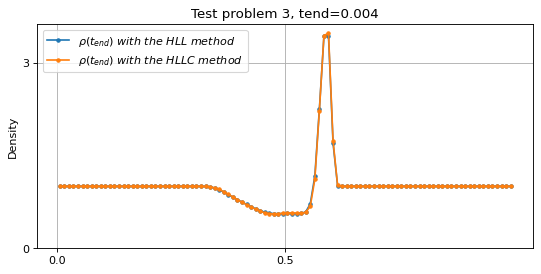

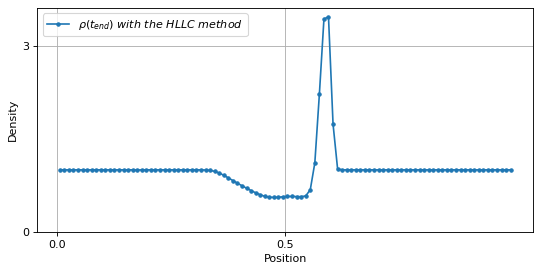

In [18]:

figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat3[0], "-", label=r"$\rho(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat3[3], "-", label=r"$\rho(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat3[6], "-", label=r"$\rho(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,3,6])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 3))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Density')
plt.title('Test problem 3, tend=0.004')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat3[6], "-", label=r"$\rho(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,3,6])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 3))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Density')
plt.xlabel('Position')
plt.grid()
plt.legend()

plt.savefig('Dt3.png')

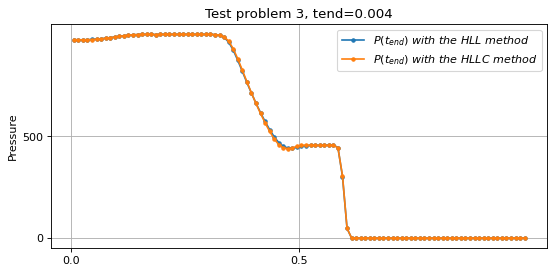

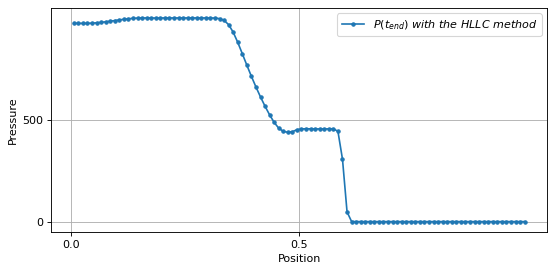

In [19]:
datat3[1][-11:]=mmp
datat3[4][-11:]=mmp
datat3[7][-11:]=mmp

figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat3[1], "-", label=r"$P(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat3[4], "-", label=r"$P(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat3[7], "-", label=r"$P(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,500,1000])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 500))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Pressure')
plt.title('Test problem 3, tend=0.004')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat3[7], "-", label=r"$P(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,500,1000])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 500))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Pressure')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.savefig('Pt3.png')

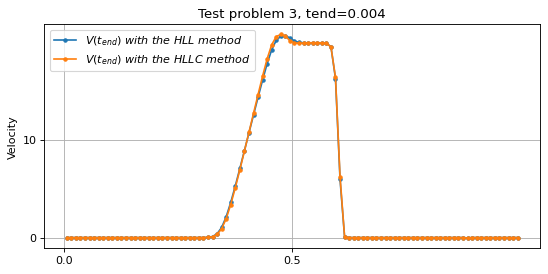

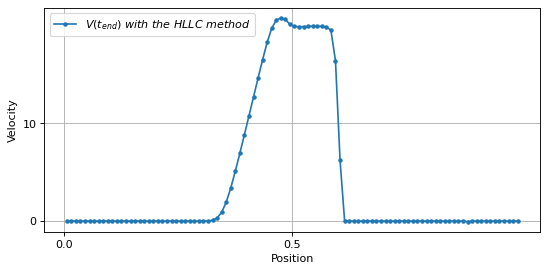

In [20]:
#add some corrections due to the lack of boundary conditions

datat3[2][:20]=mv
datat3[5][:20]=mv
datat3[8][:20]=mv

datat3[2][-11:]=mmv
datat3[5][-11:]=mmv
datat3[8][-11:]=mmv



figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat3[2], "-", label=r"$V(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat3[5], "-", label=r"$V(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat3[8], "-", label=r"$V(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,10,20])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 10))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Velocity')
plt.title('Test problem 3, tend=0.004')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat3[8], "-", label=r"$V(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,10,20])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 10))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Velocity')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.savefig('Vt3.png')


Test problem 4

In [21]:
#Test problem 4

n=100
gamma=1.4
cs=1.0
def coordinates(n, Lbox=1.0*np.pi):
    ds=Lbox/n
    # Two ways of accomplishing the same thing, either with arange or linspace
    x = np.linspace(0., Lbox, num=n, endpoint=False)+0.5*ds
    #x = ds*(np.arange(n) + 0.5)
    return ds,x

def test_problem4(u,eps,rho0):
        halfcells=int(u.n/2)
        velocity=np.zeros(u.n)
        velocity[:halfcells] = 19.5975 # velocity
        velocity[halfcells:] = -6.19633
        u.rho[:halfcells]=5.99924; u.rho[halfcells:]=5.99242
        u.Px = u.rho*velocity                    # momentum density
        # check if not an isothermal setup, and then compute the total energy
        if u.gamma != 1.:
            P=np.zeros(u.n)
            P[halfcells:]=46.0950#Pressure right
            P[:halfcells]=460.864 #Pressure left
            Eint = P / (u.gamma - 1.)
            u.Etot = Eint + 0.5 * u.Px**2 / u.rho
            
u = hd(n,gamma=gamma,cs=cs)
test_problem4(u,0,1)


md=np.max(u.rho)
mmd=np.min(u.rho)
mp=np.max(u.pressure())
mmp=np.min(u.pressure())
mv=np.max(u.velocity())
mmv=np.min(u.velocity())
me=np.max(u.Etot)
mme=np.min(u.Etot)
#wide_fig()
#plt.plot(u.x,u.Etot,'-',label='Energy');
#plt.plot(u.x,u.rho,'-',label='density');
#plt.plot(u.x,u.pressure(),'-',label='pressure');
#plt.plot(u.x,u.velocity(),'-',label='pressure');

#plt.legend();

In [22]:
methods=[LLF,HLL,HLLC00]
n=100
datat4=np.zeros((9,n)) #the first three rows correspond to the first method and it is density,pressure,Etot etc

for index,value in enumerate(methods):
    n = 100  # number of grid points
    C = 0.5  # Courant number (<0.5 for stability)
    rho0 = 1.0  # Average density
    gamma = 1.4  # Adiabatic index
    cs = 1.  # Sound speed
    pressure0 = cs**2 * gamma / rho0
    eps = 0.01  # relative amplitude of soundwave
    Slope = MonCen  # choose a slope
    Riemann_Solver =value# choose a Riemann solver

    # set up exepriment with a soundwave initial condition
    u = hd(n, gamma, cs=cs)
    test_problem4(u, eps=eps, rho0=rho0)

    periods = 1.0  # number of periods to advect
    tend = (
        periods * u.Lbox / u.cs
    )  # corresponding end time if wave moves with sound speed (cs)

    # caluclate an approximate guess for the
    # number of iterations needed
    # dt ~ C * dx / cs, since cs is the soundspeed
    # 1.5 is a safety factor, given that the phase
    # velocity of the wave may limit the time step a bit
    nt = int(1.5 * tend / (C * u.dx / cs))

    #wide_fig()
    #plt.plot(u.x, u.rho, "-", label=r"initial $\rho-\rho_0$")


    #the time to which the iteration will end
    tend = 0.02
    it = 0

    while u.t < tend and it < nt:
        dt = u.Courant(C)  # get size of dt
        if u.t + dt > tend:  # make sure we arrive at tend exactly
            dt = tend - u.t

        u = muscl(
            u, dt, Slope=Slope, Riemann_Solver=Riemann_Solver

        )  # Evolve solution by dt
        #Here we are going to set the boundaries conditions for the problem.



        # increment time and iteration count
        u.t += dt
        it += 1
    u.rho[:5]=md
    u.rho[-10:]=mmd
    if index==0:
        datat4[0,:]=np.copy(u.rho)
        datat4[1,:]=np.copy(u.pressure())
        datat4[2,:]=np.copy(u.velocity())
    elif index==1:
        datat4[3,:]=np.copy(u.rho)
        datat4[4,:]=np.copy(u.pressure())
        datat4[5,:]=np.copy(u.velocity())
    else:
        datat4[6,:]=np.copy(u.rho)
        datat4[7,:]=np.copy(u.pressure())
        datat4[8,:]=np.copy(u.velocity())
        


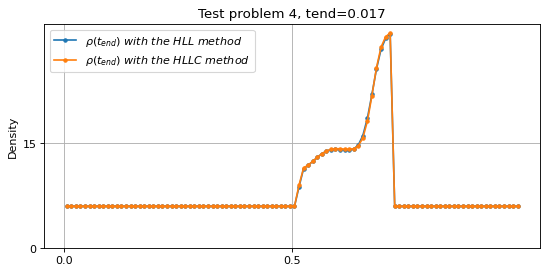

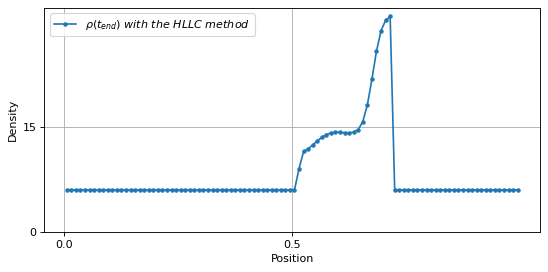

In [23]:
#add some corrections due to the lack of the boundary conditions

datat4[0][:51]=md
datat4[3][:51]=md
datat4[6][:51]=md

datat4[0][-28:]=mmd
datat4[3][-28:]=mmd
datat4[6][-28:]=mmd

figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat4[0], "-", label=r"$\rho(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat4[3], "-", label=r"$\rho(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat4[6], "-", label=r"$\rho(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,15,30])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 15))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Density')
plt.title('Test problem 4, tend=0.017')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat4[6], "-", label=r"$\rho(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,15,30])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 15))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Density')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.savefig('Dt4.png')

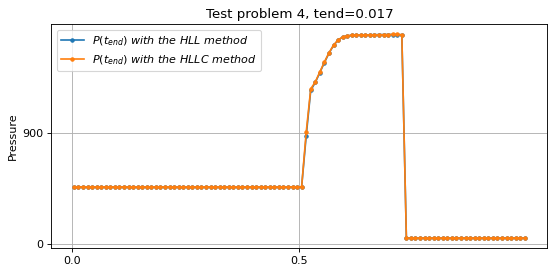

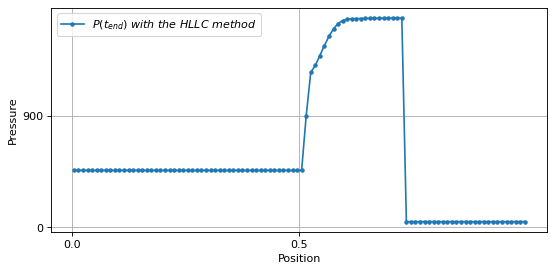

In [24]:
datat4[1][:51]=mp
datat4[4][:51]=mp
datat4[7][:51]=mp

datat4[1][-27:]=mmp
datat4[4][-27:]=mmp
datat4[7][-27:]=mmp

figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat4[1], "-", label=r"$P(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat4[4], "-", label=r"$P(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat4[7], "-", label=r"$P(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,900,1800])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 900))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Pressure')
plt.title('Test problem 4, tend=0.017')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat4[7], "-", label=r"$P(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,900,1800])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 900))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Pressure')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.savefig('Pt4.png')

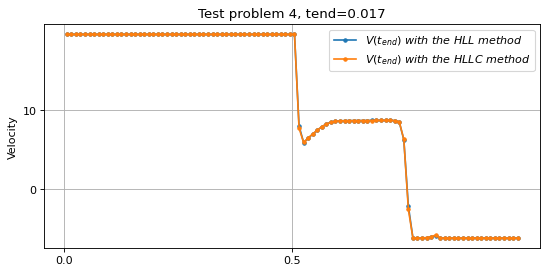

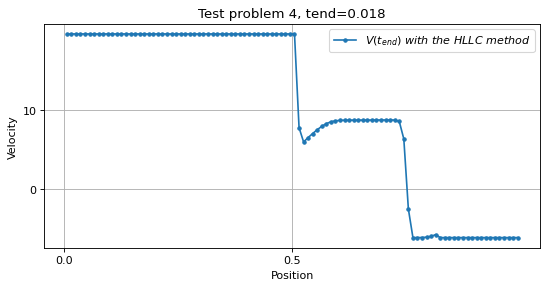

In [25]:
datat4[2][:51]=mv
datat4[5][:51]=mv
datat4[8][:51]=mv

datat4[2][-18:]=mmv
datat4[5][-18:]=mmv
datat4[8][-18:]=mmv

figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat4[2], "-", label=r"$V(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat4[5], "-", label=r"$V(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat4[8], "-", label=r"$V(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,10,20])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 10))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Velocity')
plt.title('Test problem 4, tend=0.017')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat4[8], "-", label=r"$V(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,10,20])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 10))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Velocity')
plt.title('Test problem 4, tend=0.018')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.savefig('Vt4.png')


Test problem 1

In [26]:
#Sedov problem (tend=0.1)

n=128
gamma=1.4
cs=1.1
def coordinates(n, Lbox=2.0*np.pi):
    ds=Lbox/n
    # Two ways of accomplishing the same thing, either with arange or linspace
    # x = np.linspace(0., Lbox, num=n, endpoint=False)+0.5*ds
    x = ds*(np.arange(n) + 0.5)
    return ds,x

def test_problem1(u,eps,rho0):
        halfcells=int(u.n/2)
        velocity=np.zeros(u.n)
        velocity[:halfcells] = 0.75 # velocity
        velocity[halfcells:] = 0
        u.rho[:halfcells]=1.0; u.rho[halfcells:]=0.125 # density for a sound wave with relative amplitude "eps"
        u.Px = u.rho*velocity                    # momentum density
        # check if not an isothermal setup, and then compute the total energy
        if u.gamma != 1.:
            P=np.zeros(u.n)
            P[halfcells:]=0.1; P[:halfcells]=1 #inverse the values
            Eint = P / (u.gamma - 1.)
            u.Etot = Eint + 0.5 * u.Px**2 / u.rho
            
u = hd(n,gamma=gamma,cs=cs)
test_problem1(u,0,1)
#wide_fig()
md=np.max(u.rho)
mmd=np.min(u.rho)
mp=np.max(u.pressure())
mmp=np.min(u.pressure())
mv=np.max(u.velocity())
mmv=np.min(u.velocity())
me=np.max(u.Etot)
mme=np.min(u.Etot)
#plt.plot(u.x,u.Etot,'-',label='Energy');
#plt.plot(u.x,u.rho,'-',label='density');
#plt.plot(u.x,u.pressure(),'-',label='pressure');
#plt.plot(u.x,u.velocity(),'-',label='velocity');
#plt.legend();

In [27]:
methods=[LLF,HLL,HLLC00]
n=100
datat1=np.zeros((9,n)) #the first three columns correspond to the first method and it is density,pressure,Velocity etc

for index,value in enumerate(methods):
    n = 100  # number of grid points
    C = 0.5  # Courant number (<0.5 for stability)
    rho0 = 1.0  # Average density
    gamma = 1.4  # Adiabatic index
    cs = 1.  # Sound speed
    pressure0 = cs**2 * gamma / rho0
    eps = 0.01  # relative amplitude of soundwave
    Slope = MonCen  # choose a slope
    Riemann_Solver =value# choose a Riemann solver

    # set up exepriment with a soundwave initial condition
    u = hd(n, gamma, cs=cs)
    test_problem1(u, eps=eps, rho0=rho0)

    periods = 1.0  # number of periods to advect
    tend = (
        periods * u.Lbox / u.cs
    )  # corresponding end time if wave moves with sound speed (cs)

    # caluclate an approximate guess for the
    # number of iterations needed
    # dt ~ C * dx / cs, since cs is the soundspeed
    # 1.5 is a safety factor, given that the phase
    # velocity of the wave may limit the time step a bit
    nt = int(1.5 * tend / (C * u.dx / cs))

    #wide_fig()
    #plt.plot(u.x, u.rho, "-", label=r"initial $\rho-\rho_0$")


    #the time to which the iteration will end
    tend = 0.12
    it = 0

    while u.t < tend and it < nt:
        dt = u.Courant(C)  # get size of dt
        if u.t + dt > tend:  # make sure we arrive at tend exactly
            dt = tend - u.t

        u = muscl(
            u, dt, Slope=Slope, Riemann_Solver=Riemann_Solver

        )  # Evolve solution by dt
        #Here we are going to set the boundaries conditions for the problem.



        # increment time and iteration count
        u.t += dt
        it += 1

    u.rho[:27]=md
    u.rho[-19:]=mmd
    u.Etot[:25]=me
    u.Etot[-20:]=mme
    if index==0:
        datat1[0,:]=np.copy(u.rho)
        datat1[1,:]=np.copy(u.pressure())
        datat1[2,:]=np.copy(u.velocity())
    elif index==1:
        datat1[3,:]=np.copy(u.rho)
        datat1[4,:]=np.copy(u.pressure())
        datat1[5,:]=np.copy(u.velocity())
    else:
        datat1[6,:]=np.copy(u.rho)
        datat1[7,:]=np.copy(u.pressure())
        datat1[8,:]=np.copy(u.velocity())


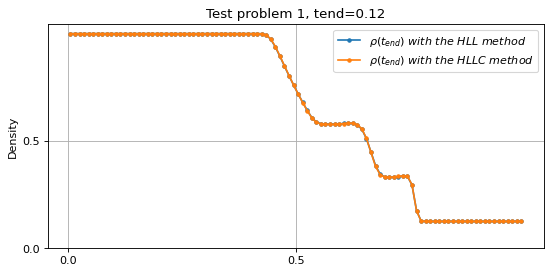

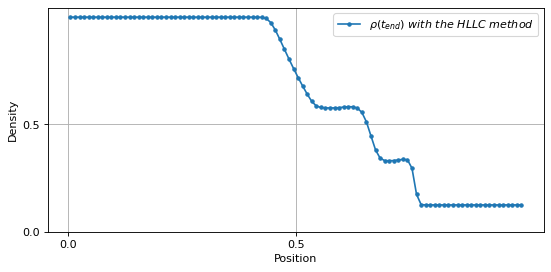

In [28]:
#make some corrections due to the fact that there are no boundaries conditions
#datat1[0][:27]=md
#datat1[3][:27]=md
#datat1[6][:27]=md

#datat1[0][-19:]=mmd
#datat1[3][-19:]=mmd
#datat1[6][-19:]=mmd



figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat1[0], "-", label=r"$\rho(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat1[3], "-", label=r"$\rho(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat1[6], "-", label=r"$\rho(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,0.5,1])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 0.5))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Density')
plt.title('Test problem 1, tend=0.12')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat1[6], "-", label=r"$\rho(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,0.5,1])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 0.5))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Density')
plt.xlabel('Position')
plt.grid()
plt.legend()


plt.savefig('Dt1.png')



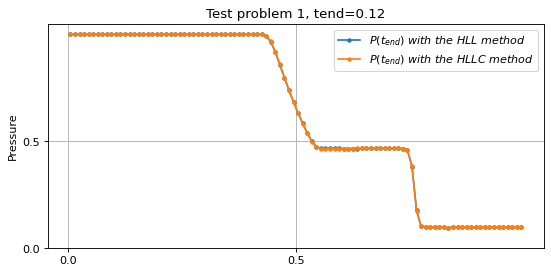

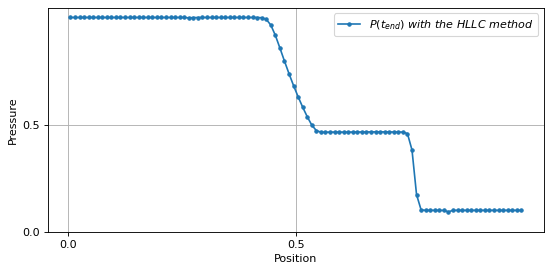

In [29]:
#add some corrections due to the fact that we are missing the boundary conditions of the pressure 

datat1[1][:26]=mp
datat1[4][:26]=mp
datat1[7][:26]=mp

datat1[1][-16:]=mmp
datat1[4][-16:]=mmp
datat1[7][-16:]=mmp


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat1[1], "-", label=r"$P(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat1[4], "-", label=r"$P(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat1[7], "-", label=r"$P(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,0.5,1])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 0.5))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Pressure')
plt.title('Test problem 1, tend=0.12')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat1[7], "-", label=r"$P(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,0.5,1])
x = np.array([0,0.5 ,1])
plt.yticks(np.arange(y.min(), y.max(), 0.5))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.ylabel('Pressure')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.savefig('Pt1.png')

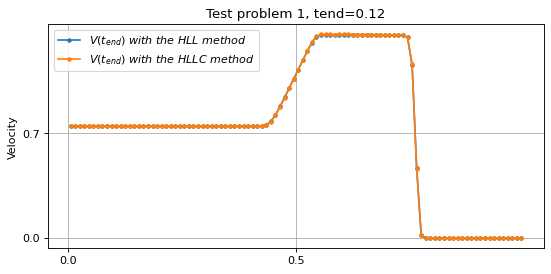

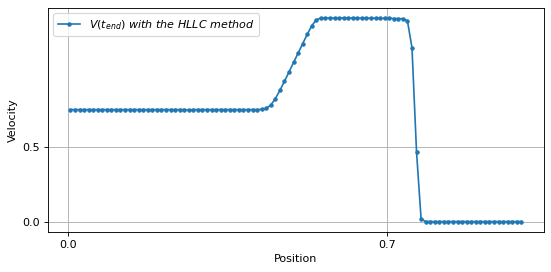

In [30]:
#add some corrections due to the fact that we are missing the boundary conditions of the pressure 

datat1[2][:26]=mv
datat1[5][:26]=mv
datat1[8][:26]=mv

datat1[2][-19:]=mmv
datat1[5][-19:]=mmv
datat1[8][-19:]=mmv


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 1)
#plt.plot(u.x, datat1[2], "-", label=r"$V(t_{end})\ with\ the\ LLF\ method$",marker='.')
plt.plot(u.x, datat1[5], "-", label=r"$V(t_{end})\ with\ the\ HLL\ method$",marker='.')
plt.plot(u.x, datat1[8], "-", label=r"$V(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,0.5,1])
x = np.array([0,0.7 ,1])
plt.yticks(np.arange(y.min(), y.max(), 0.7))
plt.xticks(np.arange(x.min(), x.max(), 0.5))
plt.grid()
plt.ylabel('Velocity')
plt.title('Test problem 1, tend=0.12')
plt.legend()


figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 1, 2)
plt.plot(u.x, datat1[8], "-", label=r"$V(t_{end})\ with\ the\ HLLC\ method$",marker='.')
y = np.array([0,0.5,1])
x = np.array([0,0.7,1.4])
plt.yticks(np.arange(y.min(), y.max(), 0.5))
plt.xticks(np.arange(x.min(), x.max(), 0.7))
plt.ylabel('Velocity')
plt.xlabel('Position')
plt.grid()
plt.legend()
plt.legend()

${\bf Blast\ Wave\ problem}$

Here we defined the HLLC Riemann solvers for a 2D problem . For this task we have written only two of the variants of this solver and their fastest version.

#### Hydrodynamics class

In [31]:
class hd():
    """ Template class for hydrodynamics, with parameters, variables and methods """
    def __init__(self,n=64,gamma=1.4,Lbox=2.,cs=None):
        """ Initialization of arrays for conservative variables """
        self.n=n                     # number of points along a coordinate axis. n*n in total
        self.Lbox=Lbox               # box size
        self.t = 0.                  # time
        self.it = 0                  # iterations
        self.gamma = gamma           # adiabatic index
        if gamma==1:                 # only set sound speed if gas isothermal
            self.cs = cs
        self.rho   = np.ones((n,n))  # density
        self.Etot  = np.ones((n,n))  # total energy
        self.Px    = np.zeros((n,n)) # momentum in x-direction
        self.Py    = np.zeros((n,n)) # momentum in y-direction
        self.coordinates()           # setup cooridnate system
    
    def coordinates(self):
        """ Coordinate initialization """
        n = self.n              # shorthand, used a lot below
        self.ds = self.Lbox/n
        self.dx = self.ds
        self.dy = self.ds
        # cell-centered coordinates are in the interval [-1+ds/2,...,1-ds/2]
        self.x = np.linspace(-self.Lbox*0.5,self.Lbox*0.5,num=self.n,endpoint=False)+0.5*self.ds 
        self.y = self.x
        # make a 2D radius function for convenience
        self.r = np.zeros((n,n))
        for i in range(n):
            self.r[i] = (self.y**2 + self.x[i]**2)**0.5 
        return self.ds,self.r
    def velocity(self):
        """ Compute velocity from conservative variables and return in (2,n,n) array """
        return np.array([self.Px/self.rho, self.Py/self.rho])

    def pressure(self):
        """ Compute pressure from conservative variables """
        if (self.gamma==1.0):
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5*(self.Px**2 + self.Py**2)/self.rho 
            P = (self.gamma-1.)*Eint
        return P

    def temperature(self):
        """ Compute the 'temperature', defined as P/rho = kB / mu T """
        return self.pressure() / self.rho
    
    def Courant(self,C=0.5):
        """ Courant condition for HD """
        v = self.velocity()
        speed = np.sqrt(v[0]**2 + v[1]**2)
        cs = np.sqrt(self.gamma*self.pressure()/self.rho)
        return C*self.ds/np.max(cs+speed)

In [32]:
# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D
    U.mU = q.D*q.U #for the x dimension of velocity
    U.mV = q.D*q.V #for the y dimension of velocity
    if q.gamma != 1: 
        Eint=q.P/(q.gamma-1.)
        U.Etot = Eint+0.5*(q.D*(q.U**2+q.V**2)) #for the total energy
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D = U.mU
    F.mU = U.mU*q.U + q.P #for the flux in the x direction
    F.mV = U.mV*q.U #for the flux in the y direction
    if q.gamma != 1:
        F.Etot = U.Etot*(q.U)+q.P*(q.U) #for the energy flux
    return F

        
    return Flux
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def MonCen(f):
    """ Monotonized central slope limiter """
    if f.ndim==1:
        ls=left_slope(f)
        rs=np.roll(ls,-1)
        cs=np.zeros(ls.shape)
        w=np.where(ls*rs>0.0)
        cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])
        return cs
    else:
        shape=np.insert(f.shape,0,f.ndim)
        slopes=np.zeros(shape)
        for i in range(f.ndim):
            ls=left_slope(f,axis=i)
            rs=np.roll(ls,-1,axis=i)
            cs=np.zeros(f.shape)
            w=np.where(ls*rs>0.0)
            cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])
            slopes[i]=cs
        return slopes
    
def imshow(f,size=10,axis=None):
    plt.figure(figsize=(size,size))
    if axis is None:
        extent = None
    else:
        extent = ([axis.min(), axis.max(), axis.min(), axis.max()])

    plt.imshow(np.transpose(f),origin='lower',extent=extent)
    plt.colorbar();
def title(e0=1e5,d0=1.0,C=0.5,n=128,solver=HLL):
    plt.title('e0={:.0e}   d0={:.0e}   C={:.1f}  n={}  {}'.format(e0,d0,C,n,solver.__name__));

#### Riemann Solvers

In [33]:

def HLL(ql,qr):
    # sound speed for each side of interface (l==left, r==right), and maxmimum sound speed (c_max)
    c_left  = (ql.gamma*ql.P/ql.D)**0.5
    c_right = (qr.gamma*qr.P/qr.D)**0.5
    c_max = np.maximum (c_left, c_right)
   

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)
    # maximum wave speeds to the left and right (guaranteed to have correct sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds. If SL < 0 and SR > 0 then mix state appropriately
    # The general form is 
    #    (SR * F_left - SL * F_right + SL * SR *(U_right - U_left)) / (SR - SL)
    # where U is the state vector of the conserved variables
    Flux = void()
    Flux.D = (SR*Fl.D-SL*Fr.D+SL*SR*(Ur.D-Ul.D))/(SR-SL)
    Flux.mU = (SR*Fl.mU-SL*Fr.mU+SL*SR*(Ur.mU-Ul.mU))/(SR-SL)
    Flux.mV = (SR*Fl.mV-SL*Fr.mV+SL*SR*(Ur.mV-Ul.mV))/(SR-SL)
    if ql.gamma != 1:
        Flux.Etot = (SR*Fl.Etot-SL*Fr.Etot+SL*SR*(Ur.Etot-Ul.Etot))/(SR-SL)
    return Flux

In [34]:
def HLLC0_2D(ql,qr): #Variant 0 of HLLC Riemann Solver
    n=len(ql.U)
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U)
    S_star=nominator/denominator
    
    #For this variant of the HLLC solver we need to calculate the total energy.
    #We know that Etotal=Eint+0.5(ρ u^2), Eint=P/(γ-1). Thus in each case we 
    #use the qr.D,qr.U,ql.D,ql.U respectively.
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star=np.zeros((4,n,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332. 
    #Now, in our case it is highly importan to mention that in the book at the relation (10.73)
    #the relation that connects U*k with the energy, the term Ek/ρk exists due to the 
    #fact that the Ek value is basically ρΕk. 
    for i in range(n):
        for j in range(n):
            if SL[i,j]>0:
                F_star[0,i,j]+=Fl.D[i,j]
                F_star[1,i,j]+=Fl.mU[i,j]
                F_star[2,i,j]+=Fl.mV[i,j]
                F_star[3,i,j]+=Fl.Etot[i,j]
            elif SL[i,j]<=0 and S_star[i,j]>=0:
                a=ql.D[i,j]*((SL[i,j]-ql.U[i,j])/(SL[i,j]-S_star[i,j]))
                F_star[0,i,j]+=Fl.D[i,j]+SL[i,j]*(a*1-Ul.D[i,j])
                F_star[1,i,j]+=Fl.mU[i,j]+SL[i,j]*(a*S_star[i,j]-Ul.mU[i,j])
                F_star[2,i,j]+=Fl.mV[i,j]+SL[i,j]*(a*ql.V[i,j]-Ul.mV[i,j])
                Energy_left=(ql.P[i,j]/(ql.gamma-1))+0.5*(ql.D[i,j]*(ql.U[i,j]*ql.U[i,j]+ql.V[i,j]*ql.V[i,j]))
                b=(Energy_left/ql.D[i,j])+(S_star[i,j]-ql.U[i,j])*(S_star[i,j]+ql.P[i,j]/(ql.D[i,j]*(SL[i,j]-ql.U[i,j])))            
                F_star[3,i,j]+=Fl.Etot[i,j]+SL[i,j]*(a*b-Ul.Etot[i,j])
            elif S_star[i,j]<0 and SR[i,j]>0:
                a=qr.D[i,j]*((SR[i,j]-qr.U[i,j])/(SR[i,j]-S_star[i,j]))
                F_star[0,i,j]+=Fr.D[i,j]+SR[i,j]*(a*1-Ur.D[i,j])
                F_star[1,i,j]+=Fr.mU[i,j]+SR[i,j]*(a*S_star[i,j]-Ur.mU[i,j])
                F_star[2,i,j]+=Fr.mV[i,j]+SR[i,j]*(a*qr.V[i,j]-Ur.mV[i,j])
                Energy_right=(qr.P[i,j]/(qr.gamma-1))+0.5*(qr.D[i,j]*(qr.U[i,j]*qr.U[i,j]+qr.V[i,j]*qr.V[i,j]))
                b=(Energy_right/qr.D[i,j])+(S_star[i,j]-qr.U[i,j])*(S_star[i,j]+qr.P[i,j]/(qr.D[i,j]*(SR[i,j]-qr.U[i,j])))            
                F_star[3,i,j]+=Fr.Etot[i,j]+SR[i,j]*(a*b-Ur.Etot[i,j])
            else:
                F_star[0,i,j]+=Fr.D[i,j]
                F_star[1,i,j]+=Fr.mU[i,j]
                F_star[2,i,j]+=Fr.mV[i,j]
                F_star[3,i,j]+=Fr.Etot[i,j]
    #We create the object of Flux
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.mV=np.copy(F_star[2,:])
    Flux.Etot=np.copy(F_star[3,:])
    return Flux
    

In [35]:
def HLLC00_2D(ql,qr): #Variant 0 of HLLC Riemann Solver
    n=len(ql.U)
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    '''
    #calculate the signal speeds with the Roe method
    u_average=(np.sqrt(ql.D)*ql.U+np.sqrt(qr.D)*qr.U)/(np.sqrt(ql.D)+np.sqrt(qr.D))
    El=(ql.P/(ql.gamma-1))+0.5*(ql.D*(ql.U**2+ql.V**2))
    Hl=(El+ql.P)/(ql.D)
    Er=(qr.P/(qr.gamma-1))+0.5*(qr.D*(qr.U**2+qr.V**2))
    Hr=(Er+qr.P)/(qr.D)
    H_average=(np.sqrt(ql.D)*Hl+np.sqrt(qr.D)*Hr)/(np.sqrt(ql.D)+np.sqrt(qr.D))
    a_average=np.sqrt((ql.gamma-1)*(H_average-0.5*u_average**2))
    SL=u_average-a_average
    SR=u_average+a_average
    '''
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U)
    S_star=nominator/denominator
    
    #For this variant of the HLLC solver we need to calculate the total energy.
    #We know that Etotal=Eint+0.5(ρ u^2), Eint=P/(γ-1). Thus in each case we 
    #use the qr.D,qr.U,ql.D,ql.U respectively.
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star=np.zeros((4,n,n))
    
    #Here we calculate the fluxes according to relation (10.71) page 332. 
    #Now, in our case it is highly importan to mention that in the book at the relation (10.73)
    #the relation that connects U*k with the energy, the term Ek/ρk exists due to the 
    #fact that the Ek value is basically ρΕk. So in our case we should use only the value of
    #the energy we have computed previously!
    #First case
    mask1 = (SL > 0)
    F_star[0][mask1] += Fl.D[mask1]
    F_star[1][mask1] += Fl.mU[mask1]
    F_star[2][mask1] += Fl.mV[mask1]
    F_star[3][mask1] += Fl.Etot[mask1]
    #Second case 
    mask2 = (S_star >= 0) & (SL <= 0)
    a=np.zeros((n,n))
    b=np.zeros((n,n))
    Energy_left=np.zeros((n,n))
    a[mask2]+=ql.D[mask2]*((SL[mask2]-ql.U[mask2])/(SL[mask2]-S_star[mask2]))
    F_star[0][mask2]+=Fl.D[mask2]+SL[mask2]*(a[mask2]*1-Ul.D[mask2])
    F_star[1][mask2]+=Fl.mU[mask2]+SL[mask2]*(a[mask2]*S_star[mask2]-Ul.mU[mask2])
    F_star[2][mask2]+=Fl.mV[mask2]+SL[mask2]*(a[mask2]*ql.V[mask2]-Ul.mV[mask2])
    Energy_left[mask2]+=(ql.P[mask2]/(ql.gamma-1))+0.5*(ql.D[mask2]*(ql.U[mask2]**2+ql.V[mask2]**2))
    b[mask2]+=(Energy_left[mask2]/ql.D[mask2])+(S_star[mask2]-ql.U[mask2])*(S_star[mask2]+ql.P[mask2]/(ql.D[mask2]*(SL[mask2]-ql.U[mask2])))            
    F_star[3][mask2]+=Fl.Etot[mask2]+SL[mask2]*(a[mask2]*b[mask2]-Ul.Etot[mask2])
    #Third case
    mask3 = (S_star < 0) & (SR > 0)
    a=np.zeros((n,n))
    b=np.zeros((n,n))
    Energy_right=np.zeros((n,n))
    a[mask3]+=qr.D[mask3]*((SR[mask3]-qr.U[mask3])/(SR[mask3]-S_star[mask3]))
    F_star[0][mask3]+=Fr.D[mask3]+SR[mask3]*(a[mask3]*1-Ur.D[mask3])
    F_star[1][mask3]+=Fr.mU[mask3]+SR[mask3]*(a[mask3]*S_star[mask3]-Ur.mU[mask3])
    F_star[2][mask3]+=Fr.mV[mask3]+SR[mask3]*(a[mask3]*qr.V[mask3]-Ur.mV[mask3])
    Energy_right[mask3]+=(qr.P[mask3]/(ql.gamma-1))+0.5*(qr.D[mask3]*(qr.U[mask3]**2+qr.V[mask3]**2))
    b[mask3]+=(Energy_right[mask3]/qr.D[mask3])+(S_star[mask3]-qr.U[mask3])*(S_star[mask3]+qr.P[mask3]/(qr.D[mask3]*(SR[mask3]-qr.U[mask3])))            
    F_star[3][mask3]+=Fr.Etot[mask3]+SR[mask3]*(a[mask3]*b[mask3]-Ur.Etot[mask3])
    #Forth case
    mask4 = (SR <= 0)
    F_star[0][mask4] += Fr.D[mask4]
    F_star[1][mask4] += Fr.mU[mask4]
    F_star[2][mask4] += Fr.mV[mask4]
    F_star[3][mask4] += Fr.Etot[mask4]
    #We create the object of Flux
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.mV=np.copy(F_star[2,:])
    Flux.Etot=np.copy(F_star[3,:])
    return Flux
    

In [36]:
def HLLC2_2D(ql,qr): #Variant 2 of HLLC Riemann Solver
    #number of points
    n=len(ql.U)
    
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U) #pR-pL+dL*uL*(SL-uL)-dR*uR*(SR-uR)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U) #dL(SL-uL)-dR(SR-uR)
    S_star=nominator/denominator
    
    #calculate pLR (page 332 in Riemman book)
    pLR=np.copy(0.5*(ql.P+qr.P+ql.D*(SL-ql.U)*(S_star-ql.U)+qr.D*(SR-qr.U)*(S_star-qr.U)))

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
     #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star=np.zeros((4,n,n))
    #Here we calculate the fluxes according to relation (10.71) page 332
    D=[0,1,0,0,S_star]
    
    for i in range(n):
        for j in range(n):
            if SL[i,j]>0:
                F_star[0,i,j]+=Fl.D[i,j]
                F_star[1,i,j]+=Fl.mU[i,j]
                F_star[2,i,j]+=Fl.mV[i,j]
                F_star[3,i,j]+=Fl.Etot[i,j]
            elif S_star[i,j]>=0 and SL[i,j]<=0:
                denom=SL[i,j]-S_star[i,j]
                F_star[0,i,j]+=(S_star[i,j]*(SL[i,j]*Ul.D[i,j]-Fl.D[i,j])+SL[i,j]*pLR[i,j]*D[0])/denom
                F_star[1,i,j]+=(S_star[i,j]*(SL[i,j]*Ul.mU[i,j]-Fl.mU[i,j])+SL[i,j]*pLR[i,j]*D[1])/denom
                F_star[2,i,j]+=(S_star[i,j]*(SL[i,j]*Ul.mV[i,j]-Fl.mV[i,j])+SL[i,j]*pLR[i,j]*D[2])/denom
                F_star[3,i,j]+=(S_star[i,j]*(SL[i,j]*Ul.Etot[i,j]-Fl.Etot[i,j])+SL[i,j]*pLR[i,j]*S_star[i,j])/denom
            elif S_star[i,j]<0 and SR[i,j]>0:
                denom=SR[i,j]-S_star[i,j]
                F_star[0,i,j]+=(S_star[i,j]*(SR[i,j]*Ur.D[i,j]-Fr.D[i,j])+SR[i,j]*pLR[i,j]*D[0])/denom
                F_star[1,i,j]+=(S_star[i,j]*(SR[i,j]*Ur.mU[i,j]-Fr.mU[i,j])+SR[i,j]*pLR[i,j]*D[1])/denom
                F_star[2,i,j]+=(S_star[i,j]*(SR[i,j]*Ur.mV[i,j]-Fr.mV[i,j])+SR[i,j]*pLR[i,j]*D[2])/denom
                F_star[3,i,j]+=(S_star[i,j]*(SR[i,j]*Ur.Etot[i,j]-Fr.Etot[i,j])+SR[i,j]*pLR[i,j]*S_star[i,j])/denom
            elif SR[i,j]<=0:
                F_star[0,i,j]+=Fr.D[i,j]
                F_star[1,i,j]+=Fr.mU[i,j]
                F_star[2,i,j]+=Fr.mV[i,j]
                F_star[3,i,j]+=Fr.Etot[i,j]
    Flux=void()
    Flux.D=np.copy(F_star[0,:])
    Flux.mU=np.copy(F_star[1,:])
    Flux.mV=np.copy(F_star[2,:])
    Flux.Etot=np.copy(F_star[3,:])




    return Flux

In [37]:
def HLLC22_2D(ql,qr): #Variant 2 (faster version)
    #number of points
    n=len(ql.U)
    
    #Even though in the book there is another formulation of calculating the SL and SR wave speeds
    #we chose the one below as it is more strict and more conservative. On the other hand the one
    #proposed to the book it is more diffusive in comparison to the one below!
    
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    #calculation of the S*
    nominator=qr.P-ql.P+ql.D*ql.U*(SL-ql.U)-qr.D*qr.U*(SR-qr.U) #pR-pL+dL*uL*(SL-uL)-dR*uR*(SR-uR)
    denominator=ql.D*(SL-ql.U)-qr.D*(SR-qr.U) #dL(SL-uL)-dR(SR-uR)
    S_star=nominator/denominator
    
    #calculate pLR (page 332 in Riemman book)
    pLR=np.copy(0.5*(ql.P+qr.P+ql.D*(SL-ql.U)*(S_star-ql.U)+qr.D*(SR-qr.U)*(S_star-qr.U)))

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
       
    
    #Here we calculate the fluxes according to relation (10.71) page 332
   
    D=[0,1,0,0,S_star]
    
    
    #We define 3 arrays which are correlated to the fluxes of density (0), velocity(1) and energy(2)
    F_star = np.zeros((4,n,n))

    #First case
    mask1 = (SL > 0)
    F_star[0][mask1] += Fl.D[mask1]
    F_star[1][mask1] += Fl.mU[mask1]
    F_star[2][mask1] += Fl.mV[mask1]
    F_star[3][mask1] += Fl.Etot[mask1]
    #Second case
    mask2 = (S_star >= 0) & (SL <= 0)
    #if mask2.shape != SL.shape or mask2.shape != S_star.shape:
     #   raise ValueError("Shape of mask2 does not match shape of SL or S_star")
    denom = np.zeros((n,n))
    denom[mask2] = SL[mask2] - S_star[mask2]
    F_star[0][mask2] += (S_star[mask2] * (SL[mask2] * Ul.D[mask2] - Fl.D[mask2]) + SL[mask2] * pLR[mask2] * 0) / denom[mask2]
    F_star[1][mask2] += (S_star[mask2] * (SL[mask2] * Ul.mU[mask2] - Fl.mU[mask2]) + SL[mask2] * pLR[mask2] * 1) / denom[mask2]
    F_star[2][mask2] += (S_star[mask2] * (SL[mask2] * Ul.mV[mask2] - Fl.mV[mask2]) + SL[mask2] * pLR[mask2] * 0) / denom[mask2]
    F_star[3][mask2] += (S_star[mask2] * (SL[mask2] * Ul.Etot[mask2] - Fl.Etot[mask2]) + SL[mask2] * pLR[mask2] * S_star[mask2]) / denom[mask2]
    #Third case
    mask3 = (S_star < 0) & (SR > 0)
    denom = np.zeros((n,n))
    denom[mask3] = SR[mask3] - S_star[mask3]
    F_star[0][mask3] += (S_star[mask3] * (SR[mask3] * Ur.D[mask3] - Fr.D[mask3]) + SR[mask3] * pLR[mask3] * 0) / denom[mask3]
    F_star[1][mask3] += (S_star[mask3] * (SR[mask3] * Ur.mU[mask3] - Fr.mU[mask3]) + SR[mask3] * pLR[mask3] * 1) / denom[mask3]
    F_star[2][mask3] += (S_star[mask3] * (SR[mask3] * Ur.mV[mask3] - Fr.mV[mask3]) + SR[mask3] * pLR[mask3] * 0) / denom[mask3]
    F_star[3][mask3] += (S_star[mask3] * (SR[mask3] * Ur.Etot[mask3] - Fr.Etot[mask3]) + SR[mask3] * pLR[mask3] * S_star[mask3]) / denom[mask3]
    #Forth case
    mask4 = (SR <= 0)
    F_star[0][mask4] += Fr.D[mask4]
    F_star[1][mask4] += Fr.mU[mask4]
    F_star[2][mask4] += Fr.mV[mask4]
    F_star[3][mask4] += Fr.Etot[mask4]

    Flux=void()
    Flux.D=np.copy(F_star[0,:,:])
    Flux.mU=np.copy(F_star[1,:,:])
    Flux.mV=np.copy(F_star[2,:,:])
    Flux.Etot=np.copy(F_star[3,:,:])

    return Flux

In [38]:
def muscl_2d (u, dt, Slope=MonCen, Riemann_Solver=HLL):
    ds   = u.ds
    ids  = 1. / u.ds # 1 / cell size, useful for derivatives below
    dtds = dt/u.ds
    

    # 1) Compute primitive variables (rho, v, P)
    # make sure to copy u.rho to D, otherwise D becomes a "pointer" to u.rho, and updates itself in 7)
    D = np.copy(u.rho)         # D: density (n,n)
    v = u.velocity()           # v: velocity (2,n,n)
    P = u.pressure()           # P: pressure (n,n)
    # 2) Compute slope limited derivatives based on centered points
    dD = Slope(D) * ids        # returns (2,n,n) 
    dP = Slope(P) * ids        # returns (2,n,n)
    dv0 = Slope(v[0]) * ids    # returns (2,n,n)
    dv1 = Slope(v[1]) * ids    # returns (2,n,n)
    dv = np.array([dv0,dv1])   # shape = (2,2,n,n)

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    
    # Time evolution with source terms
    div = dv[0,0] + dv[1,1] # div(v)
    D_t = - v[0]*dD[0] - v[1]*dD[1] - D*div  # dD/dt = -v*grad(D) - D*div(v)
    P_t = - v[0]*dP[0] - v[1]*dP[1] - u.gamma*P*div   # dP/dt = -v*grad(P) - gamma*P*div(v)
    v_t = np.empty_like(v)                   # create empty array with shape = (2,n,n)
    v_t[0] = - v[0]*dv[0,0] - v[1]*dv[0,1] - dP[0]/D  # dv/dt = -v*grad(v) - grad(P)/D
    v_t[1] = - v[0]*dv[1,0] - v[1]*dv[1,1] - dP[1]/D
    # Loop over X- and Y-direction
    for axis in range(2):
        ql = void(); ql.gamma = u.gamma
        qr = void(); qr.gamma = u.gamma
        
        # Calculates the parallel and perpendicular velocities to the coordinate direction
        # X-axis: iu=0, iv=1, Y-axis: iu=1, iv=0
        iu = axis
        iv = (axis + 1) % 2
        # Parallel (U) and perpendicular (V) velocities
        U = v[iu]; dU = dv[iu]; U_t = v_t[iu]
        V = v[iv]; dV = dv[iv]; V_t = v_t[iv]

        # 4) Spatial interpolation "axis"-direction + time terms

        # left state -- AS SEEN FROM THE INTERFACE
        ql.D = D + 0.5*(dt*D_t + ds*dD[axis])
        ql.P = P + 0.5*(dt*P_t + ds*dP[axis]) 
        ql.U = U + 0.5*(dt*U_t + ds*dU[axis])
        ql.V = V + 0.5*(dt*V_t + ds*dV[axis])
        

        # right state -- AS SEEN FROM THE INTERFACE
        qr.D = D + 0.5*(dt*D_t - ds*dD[axis])
        qr.P = P + 0.5*(dt*P_t - ds*dP[axis])
        qr.U = U + 0.5*(dt*U_t - ds*dU[axis])
        qr.V = V + 0.5*(dt*V_t - ds*dV[axis])

        # 5) Roll down -1 in the "axis" direction so that we collect
        #    left and right state (as seen from the interface) at the same grid index
        qr.D = np.roll(qr.D,-1,axis=axis)
        qr.P = np.roll(qr.P,-1,axis=axis)
        qr.U = np.roll(qr.U,-1,axis=axis)
        qr.V = np.roll(qr.V,-1,axis=axis)

        # 6) Solve for flux based on interface values
        Flux = Riemann_Solver(ql,qr)

        # 7) Update conserved variables with fluxes
        u.rho  -= dtds * (Flux.D - np.roll(Flux.D,1,axis=axis))
        if u.gamma != 1:
            u.Etot -= dtds * (Flux.Etot - np.roll(Flux.Etot,1,axis=axis))
        if axis==0: # X-axis
            u.Px   -= dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))
            u.Py   -= dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
        if axis==1: # Y-axis
            u.Px   -= dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
            u.Py   -= dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))

    u.t  += dt # update time
    u.it += 1  # update number of iterations

    return u

#### Blast wave class

In [39]:
class blast_wave(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e2,d0=0.0,power=2,w=3.,eps=0.05):
        hd.__init__(u,n)
        u.gamma = gamma
        u.rho  = np.ones((n,n))
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        u.Etot = np.ones((n,n)) + profile

52.3 sec, 1.45 microseconds/update


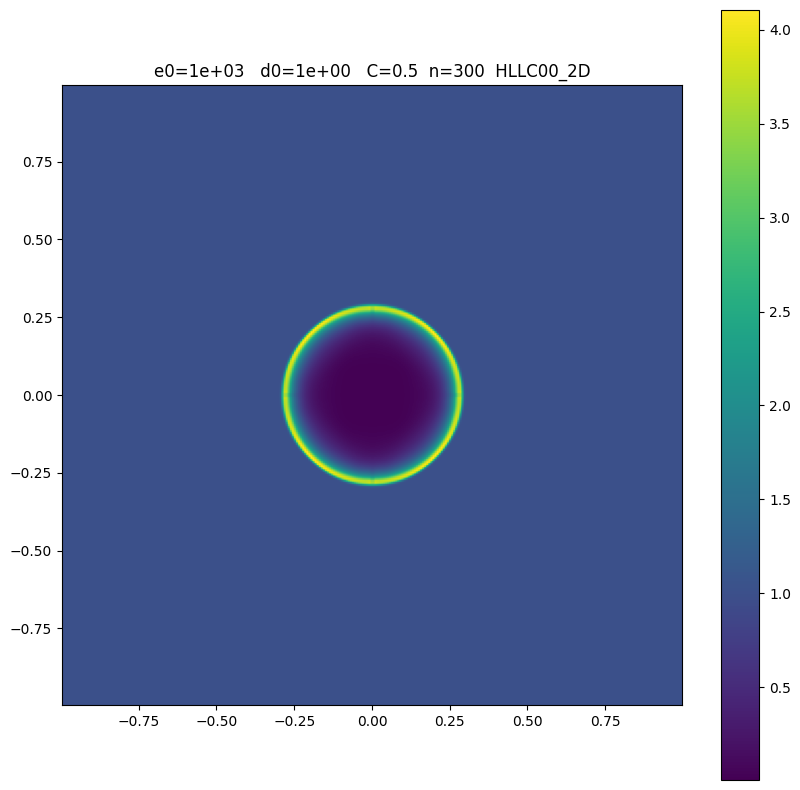

In [40]:
e0 = 1e3
n = 300
C = 0.5
nt = 400
solver = HLLC00_2D
u = blast_wave(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u_sol=[]
ut_sol=[]
uE_sol=[]
for it in range(nt):
    dt=u.Courant(C)
    u = muscl_2d(u,dt,Slope=MonCen,Riemann_Solver=solver)
    u_sol.append(np.copy(u.rho))
    ut_sol.append(np.copy(u.t))
    uE_sol.append(np.copy(u.Etot))

u_sol=np.asarray(u_sol)
shock_front=np.ones(len(u_sol))
for i, sol in enumerate(u_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front[i]=u.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u.rho,axis=u.x)
title(e0=e0,C=C,n=n,solver=solver)
plt.savefig('BLHLC00.png')

#plt.loglog(ut_sol,shock_front)
#plt.show()


23.9 sec, 0.67 microseconds/update


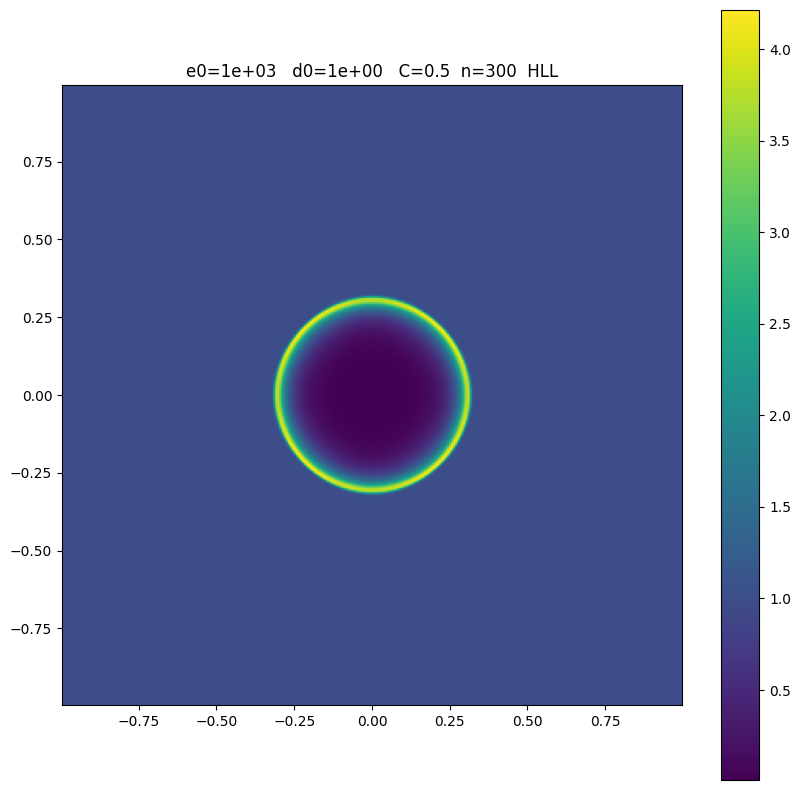

In [41]:
e0 = 1e3
n = 300
C = 0.5
nt = 400
solver = HLL
u = blast_wave(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u_sol=[]
ut_sol=[]
uE_sol=[]
for it in range(nt):
    dt=u.Courant(C)
    u = muscl_2d(u,dt,Slope=MonCen,Riemann_Solver=solver)
    u_sol.append(np.copy(u.rho))
    ut_sol.append(np.copy(u.t))
    uE_sol.append(np.copy(u.Etot))

u_sol=np.asarray(u_sol)
shock_front=np.ones(len(u_sol))
for i, sol in enumerate(u_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front[i]=u.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u.rho,axis=u.x)
title(e0=e0,C=C,n=n,solver=solver)
plt.savefig('BLHLL.png')

#plt.loglog(ut_sol,shock_front)
#plt.show()


#### Blast wave class with a density profile

In [42]:
class blast_wave2(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.5,m0=0.5):
        hd.__init__(u,n)
        u.gamma = gamma
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        profiled=B*m0*exponent
        u.Etot = np.ones((n,n)) + profile
        u.rho  = np.ones((n,n)) + profiled

21.0 sec, 1.16 microseconds/update


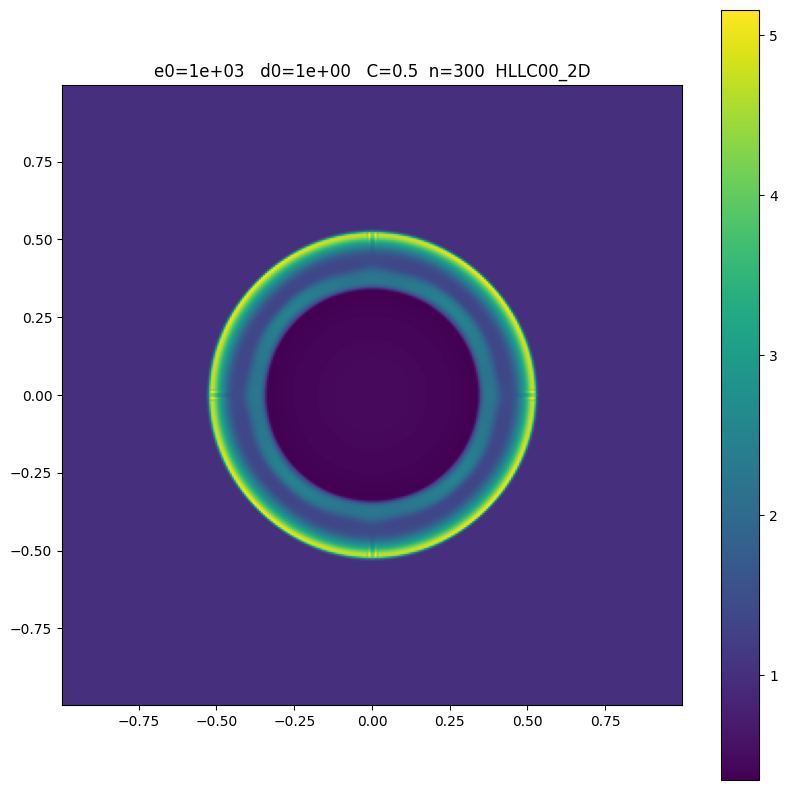

In [43]:
e0 = 1e3
m0=0.5
n = 300
C = 0.5
nt = 200
solver = HLLC00_2D
u1 = blast_wave2(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.5)
start = time()
u1_sol=[]
u1t_sol=[]
u1E_sol=[]
for it in range(nt):
    dt=u1.Courant(C)
    u1 = muscl_2d(u1,dt,Slope=MonCen,Riemann_Solver=solver)
    u1_sol.append(np.copy(u.rho))
    u1t_sol.append(np.copy(u.t))
    u1E_sol.append(np.copy(u.Etot))

u1_sol=np.asarray(u1_sol)
shock_front1=np.ones(len(u1_sol))
for i, sol in enumerate(u1_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front1[i]=u1.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u1.rho,axis=u1.x)
title(e0=e0,C=C,n=n,solver=solver)
plt.savefig('BL2HLC00.png')

#plt.loglog(ut_sol,shock_front)
#plt.show()


12.4 sec, 0.69 microseconds/update


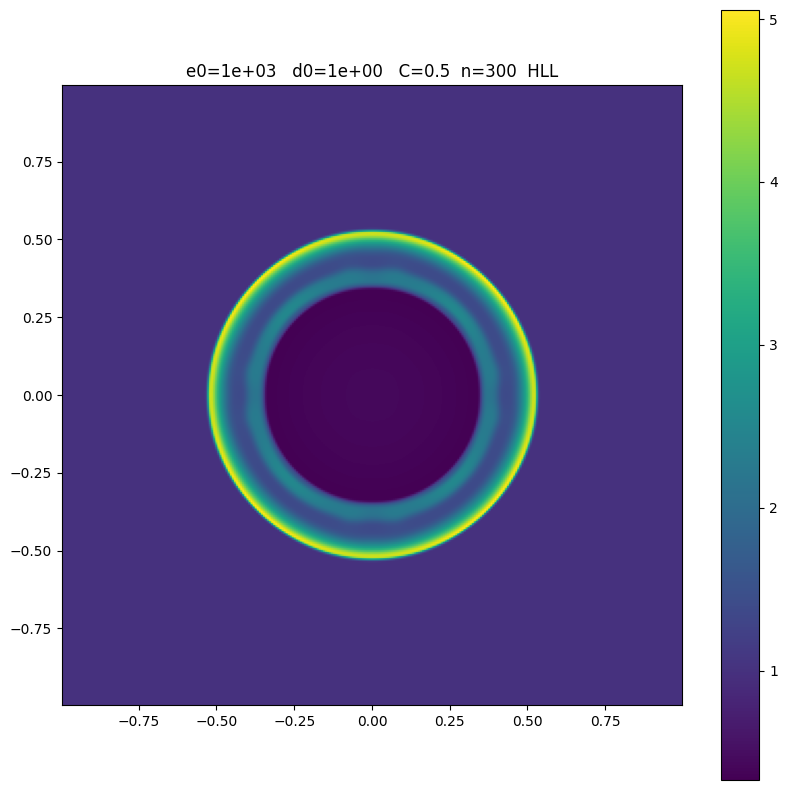

In [44]:
e0 = 1e3
m0=0.5
n = 300
C = 0.5
nt = 200
solver = HLL
u1 = blast_wave2(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.5)
start = time()
u1_sol=[]
u1t_sol=[]
u1E_sol=[]
for it in range(nt):
    dt=u1.Courant(C)
    u1 = muscl_2d(u1,dt,Slope=MonCen,Riemann_Solver=solver)
    u1_sol.append(np.copy(u.rho))
    u1t_sol.append(np.copy(u.t))
    u1E_sol.append(np.copy(u.Etot))

u1_sol=np.asarray(u1_sol)
shock_front1=np.ones(len(u1_sol))
for i, sol in enumerate(u1_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front1[i]=u1.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u1.rho,axis=u1.x)
title(e0=e0,C=C,n=n,solver=solver)
plt.savefig('BL2HL.png')

#plt.loglog(ut_sol,shock_front)
#plt.show()
